# ResNet for fast training on CIFAR10

Model architecture based on https://myrtle.ai/learn/how-to-train-your-resnet/ and https://github.com/tysam-code/hlb-CIFAR10

## Configuration

Imports

In [1]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite.metrics
import ignite.contrib.handlers

Configuration

In [2]:
DATA_DIR='./data'

NUM_CLASSES = 10
NUM_WORKERS = 8
BATCH_SIZE = 32 #1024
EPOCHS = 20
LEARNING_RATE = 1e-2
WEIGHT_DECAY = 1e-2

In [3]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


## Data

In [4]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.1)
])

In [5]:
train_dset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_transform)
test_dset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False,
                                          num_workers=NUM_WORKERS, pin_memory=True)

In [7]:
def dataset_show_image(dset, idx):
    X, Y = dset[idx]
    title = "Ground truth: {}".format(dset.classes[Y])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.imshow(np.moveaxis(X.numpy(), 0, -1))
    ax.set_title(title)
    plt.show()

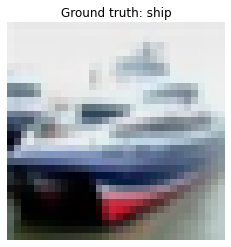

In [8]:
dataset_show_image(test_dset, 1)

## Model

In [9]:
class ConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, act=True):
        padding = (kernel_size - 1) // 2
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels)
        ]
        if act: layers.append(nn.ReLU(inplace=True))
        super().__init__(*layers)

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.residual = nn.Sequential(
            ConvBlock(channels, channels, 3),
            ConvBlock(channels, channels, 3, act=False)
        )
        self.act = nn.ReLU(inplace=True)
        self.γ = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        out = x + self.γ * self.residual(x)
        out = self.act(out)
        return out

In [11]:
class DownBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            ConvBlock(in_channels, out_channels, 3),
            nn.MaxPool2d(2)
        )

In [12]:
class ResidualLayer(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            DownBlock(in_channels, out_channels),
            ResidualBlock(out_channels)
        )

In [13]:
class TemperatureScaler(nn.Module):
    def __init__(self, scaling_factor=0.1):
        super().__init__()
        self.scaler = nn.Parameter(torch.tensor(scaling_factor))

    def forward(self, x):
        return x * self.scaler

In [14]:
class Head(nn.Sequential):
    def __init__(self, in_channels, classes):
        super().__init__(
            nn.AdaptiveMaxPool2d(1),
            nn.Flatten(),
            nn.Linear(in_channels, classes),
            TemperatureScaler()
        )

In [15]:
class Net(nn.Sequential):
    def __init__(self, classes, hidden_channels, in_channels=3):
        channels = [hidden_channels * 2**num for num in range(4)]
        super().__init__(
            ConvBlock(in_channels, hidden_channels, 3),
            ResidualLayer(channels[0], channels[1]),
            DownBlock(channels[1], channels[2]),
            ResidualLayer(channels[2], channels[3]),
            Head(channels[3], classes)
        )

In [16]:
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [17]:
model = Net(NUM_CLASSES, hidden_channels=64).to(DEVICE);

In [18]:
model.apply(init_linear);

In [19]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 6,573,133


## Training

In [20]:
loss = nn.CrossEntropyLoss(label_smoothing=0.1)

In [21]:
optimizer = optim.AdamW(model.parameters(), lr=1e-6, weight_decay=WEIGHT_DECAY)

In [22]:
trainer = create_supervised_trainer(model, optimizer, loss, device=DEVICE)

In [23]:
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)

In [24]:
trainer.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step());

In [25]:
ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

In [26]:
val_metrics = {"accuracy": ignite.metrics.Accuracy(), "loss": ignite.metrics.Loss(loss)}

In [27]:
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=DEVICE)

In [28]:
history = defaultdict(list)

In [29]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"]
    history['train loss'].append(train_loss)
    
    evaluator.run(test_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["accuracy"]
    history['val loss'].append(val_loss)
    history['val acc'].append(val_acc)
    
    print("{}/{} - train: loss {:.3f}; val: loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, val_loss, val_acc))

In [30]:
trainer.run(train_loader, max_epochs=EPOCHS);

1/20 - train: loss 1.223; val: loss 1.189 accuracy 0.714
2/20 - train: loss 1.112; val: loss 1.150 accuracy 0.734
3/20 - train: loss 1.023; val: loss 1.029 accuracy 0.787
4/20 - train: loss 0.982; val: loss 1.101 accuracy 0.739
5/20 - train: loss 0.983; val: loss 1.242 accuracy 0.688
6/20 - train: loss 0.916; val: loss 1.014 accuracy 0.792
7/20 - train: loss 0.899; val: loss 0.910 accuracy 0.839
8/20 - train: loss 0.839; val: loss 0.846 accuracy 0.861
9/20 - train: loss 0.821; val: loss 0.828 accuracy 0.866
10/20 - train: loss 0.814; val: loss 0.836 accuracy 0.863
11/20 - train: loss 0.780; val: loss 0.779 accuracy 0.889
12/20 - train: loss 0.750; val: loss 0.774 accuracy 0.894
13/20 - train: loss 0.701; val: loss 0.760 accuracy 0.901
14/20 - train: loss 0.682; val: loss 0.721 accuracy 0.919
15/20 - train: loss 0.636; val: loss 0.710 accuracy 0.922
16/20 - train: loss 0.614; val: loss 0.682 accuracy 0.929
17/20 - train: loss 0.592; val: loss 0.667 accuracy 0.936
18/20 - train: loss 0.5

In [31]:
def history_plot_train_val(history, key):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xs = np.arange(1, len(history['train ' + key]) + 1)
    ax.plot(xs, history['train ' + key], '.-', label='train')
    ax.plot(xs, history['val ' + key], '.-', label='val')
    ax.set_xlabel('epoch')
    ax.set_ylabel(key)
    ax.legend()
    ax.grid()
    plt.show()

In [32]:
def history_plot(history, key):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xs = np.arange(1, len(history[key]) + 1)
    ax.plot(xs, history[key], '.-')
    ax.set_xlabel('epoch')
    ax.set_ylabel(key)
    ax.grid()
    plt.show()

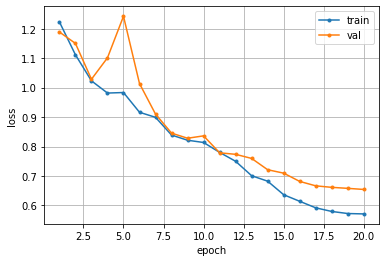

In [33]:
history_plot_train_val(history, 'loss')

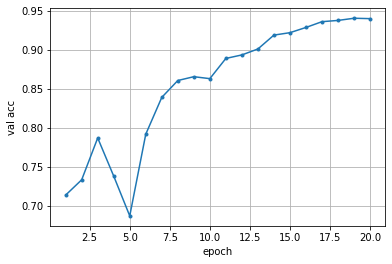

In [34]:
history_plot(history, 'val acc')